## Dataset Normalization Experiments <a class="anchor" id="topo"></a>

This notebook serves a playground for testing different audio amplitude normalization techniques on a small subset of the dataset.

### Summary

* [Part 1: Notebook setup](#part_01)
* [Part 2: Dataframe loading and subset extraction](#part_02)
* [Part 3: Normalization of the subset](#part_03)

### Part 1: Notebook Setup <a class="anchor" id="part_01"></a>

In this section, the necessary libraries are imported, the global variables are assigned and all functions are defined.

##### Import necessary libraries and define global variables

In [1]:
import os

import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import soundfile as sf
from tqdm import tqdm

PATH_TO_DATASET = "/home/lozavival/Documents/AUDIOS-Dataset"

print("Done!")

Done!


##### Define functions that will be used

In [2]:
# Amplitude calculation related functions

def get_amplitude(filename):
    try:
        audio_path = os.path.join(PATH_TO_DATASET, filename)
        y, sr = librosa.load(audio_path, sr=None)
        return np.max(y) - np.min(y)
    except Exception as e:
        print(f"Could not load file {filename}: {e}")
        return None


def get_normalized_amplitude(filename):
    file_path = os.path.dirname(filename)
    file_name = os.path.basename(filename)
    normalized_file_path = os.path.join(file_path + "_normalized", file_name)
    return get_amplitude(normalized_file_path)


def calculate_amplitudes(data, normalized):
    if normalized:
        data["amplitude"] = data["file"].apply(get_normalized_amplitude)
    else:
        data["amplitude"] = data["file"].apply(get_amplitude)
    print("Calculation of amplitudes done\n")

In [3]:
# Audio normalization related functions

def rms_normalize(audio, target_rms=0.1):
    """
    Normalize an audio signal to a target RMS energy level.
    """
    rms = np.sqrt(np.mean(audio**2))
    if rms == 0:
        return audio  # Avoid division by zero
    return audio * (target_rms / rms)


def z_score_normalize(audio):
    """
    Standardize an audio signal to have zero mean and unit variance.
    """
    mean = np.mean(audio)
    std = np.std(audio)
    if std == 0:
        return audio  # Avoid division by zero
    return (audio - mean) / std


def peak_normalize(audio):
    """
    Normalize audio to have a peak amplitude of 1.
    """
    peak = np.max(np.abs(audio))
    if peak == 0:
        return audio  # Avoid division by zero
    return audio / peak


def normalize_audio_file(filename, norm_func, **kwargs):
    try:
        audio_path = os.path.join(PATH_TO_DATASET, filename)
        audio, sr = librosa.load(audio_path, sr=None)

        if len(kwargs) > 0:
            normalized_audio = norm_func(audio, kwargs["target_rms"])
        else:
            normalized_audio = norm_func(audio)

        output_folder = os.path.dirname(filename) + "_normalized"
        output_path = os.path.join(PATH_TO_DATASET, output_folder)
        if not os.path.exists(output_path):
            os.makedirs(output_path)

        output_file = os.path.join(output_path, os.path.basename(filename))
        sf.write(output_file, normalized_audio, sr)
        # print(f"Normalized audio saved to {output_file}")
    except Exception as e:
        print(f"Error processing {filename}: {e}")


def normalize_dataset(dataset, norm_func, **kwargs):
    print("Normalizing dataset...")
    for file in tqdm(dataset["file"]):
        normalize_audio_file(file, norm_func, **kwargs)
    print("Normalization finished!\n")

In [4]:
# Data visualization related functions

def plot_boxplot(data, title):
    # Create the boxplot
    plt.figure(figsize=(6, 6))
    sns.boxplot(data=data, x="label", y="amplitude")

    # Customize the plot
    plt.title(f"Audio Amplitude per Class - {title}", fontsize=14)
    plt.xlabel("Class", fontsize=12)
    plt.ylabel("Amplitude", fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

    # Show the plot
    plt.show()


def analyze(data, title):
    # Calculate the mean amplitude of each class
    print(f"Amplitude mean of each class - {title}:\n")
    print(data.groupby("label")["amplitude"].mean())

    # Create the boxplot
    plot_boxplot(data, title)

### Part 2: Dataframe loading and subset extraction <a class="anchor" id="part_02"></a>

In this section, the dataset csv file is loaded into a pandas dataframe and a subset is extracted from it.

In [5]:
dataset_metadata_df = pd.read_csv(os.path.join(PATH_TO_DATASET, 'meta.csv'), keep_default_na=False)
dataset_metadata_df

,file,speaker,id,gender,duration,label
0,fake_voices/Paula_F026_Fake/590_fake.wav,Paula,F026,F,3.434667,spoof
1,fake_voices/Paula_F026_Fake/337_fake.wav,Paula,F026,F,4.917333,spoof
2,fake_voices/Paula_F026_Fake/469_fake.wav,Paula,F026,F,3.616000,spoof
3,fake_voices/Paula_F026_Fake/664_fake.wav,Paula,F026,F,5.429333,spoof
4,fake_voices/Paula_F026_Fake/72_fake.wav,Paula,F026,F,3.754667,spoof
...,...,...,...,...,...,...
179809,real_voices/Roseoliveira_F048/F048-0846.wav,Roseoliveira,F048,F,6.208000,bona-fide
179810,real_voices/Roseoliveira_F048/F048-0249.wav,Roseoliveira,F048,F,5.056000,bona-fide
179811,real_voices/Roseoliveira_F048/F048-0849.wav,Roseoliveira,F048,F,7.616000,bona-fide
179812,real_voices/Roseoliveira_F048/F048-0548.wav,Roseoliveira,F048,F,5.600000,bona-fide


In [6]:
# Extract data for speaker F026
f026_df = dataset_metadata_df.where(dataset_metadata_df["id"] == "F026").dropna()
f026_df

,file,speaker,id,gender,duration,label
0,fake_voices/Paula_F026_Fake/590_fake.wav,Paula,F026,F,3.434667,spoof
1,fake_voices/Paula_F026_Fake/337_fake.wav,Paula,F026,F,4.917333,spoof
2,fake_voices/Paula_F026_Fake/469_fake.wav,Paula,F026,F,3.616000,spoof
3,fake_voices/Paula_F026_Fake/664_fake.wav,Paula,F026,F,5.429333,spoof
4,fake_voices/Paula_F026_Fake/72_fake.wav,Paula,F026,F,3.754667,spoof
...,...,...,...,...,...,...
93810,real_voices/Paula_F026/F026-0677.wav,Paula,F026,F,3.440000,bona-fide
93811,real_voices/Paula_F026/F026-0625.wav,Paula,F026,F,3.488000,bona-fide
93812,real_voices/Paula_F026/F026-0983.wav,Paula,F026,F,4.045000,bona-fide
93813,real_voices/Paula_F026/F026-0949.wav,Paula,F026,F,4.160000,bona-fide


### Part 3: Normalization of the subset <a class="anchor" id="part_03"></a>

In this section, different normalization techniques, namely target RMS, peak and z-score, are applied to the subset of data and the results are compared.

##### Original Files

Calculation of amplitudes done

Amplitude mean of each class - Original:

label
bona-fide    0.747836
spoof        1.465018
Name: amplitude, dtype: float32


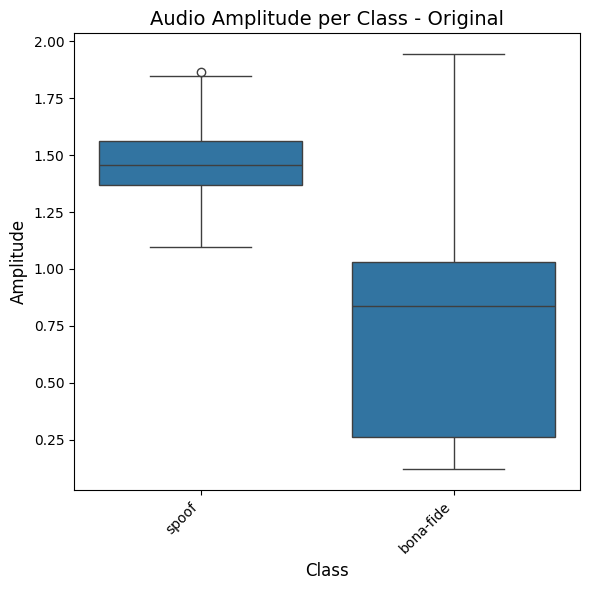

In [7]:
calculate_amplitudes(f026_df, normalized=False)
analyze(f026_df, "Original")

##### RMS Normalization

Normalizing dataset...


100%|██████████| 1916/1916 [00:12<00:00, 150.98it/s]


Normalization finished!

Calculation of amplitudes done

Amplitude mean of each class - 0.01 RMS Normalization:

label
bona-fide    0.135665
spoof        0.106296
Name: amplitude, dtype: float32


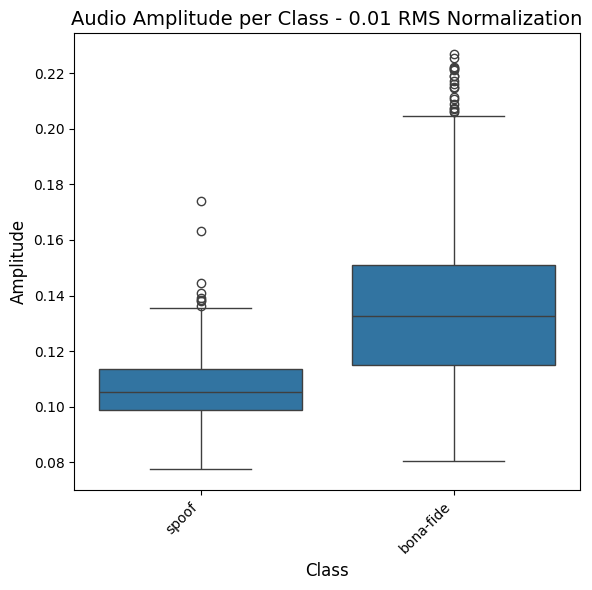

In [8]:
normalize_dataset(f026_df, rms_normalize, target_rms=0.01)
calculate_amplitudes(f026_df, normalized=True)
analyze(f026_df, "0.01 RMS Normalization")

Normalizing dataset...


100%|██████████| 1916/1916 [00:14<00:00, 131.82it/s]


Normalization finished!

Calculation of amplitudes done

Amplitude mean of each class - 0.1 RMS Normalization:

label
bona-fide    1.348971
spoof        1.062898
Name: amplitude, dtype: float32


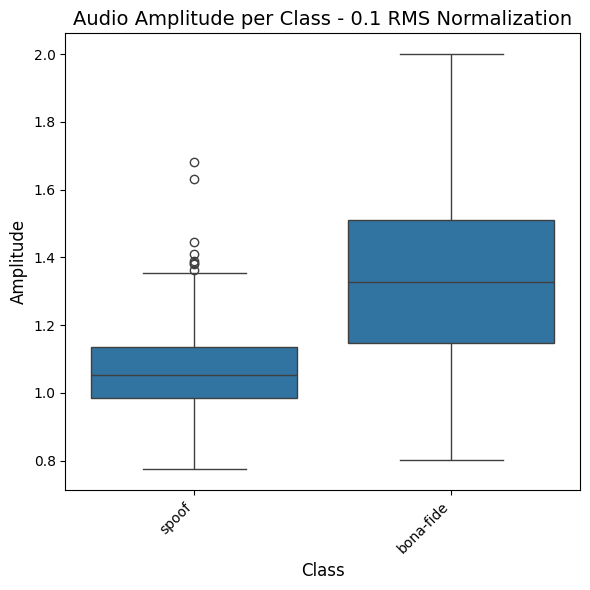

In [9]:
normalize_dataset(f026_df, rms_normalize, target_rms=0.1)
calculate_amplitudes(f026_df, normalized=True)
analyze(f026_df, "0.1 RMS Normalization")

Normalizing dataset...


100%|██████████| 1916/1916 [00:17<00:00, 110.86it/s]


Normalization finished!

Calculation of amplitudes done

Amplitude mean of each class - 0.2 RMS Normalization:

label
bona-fide    1.971005
spoof        1.897782
Name: amplitude, dtype: float32


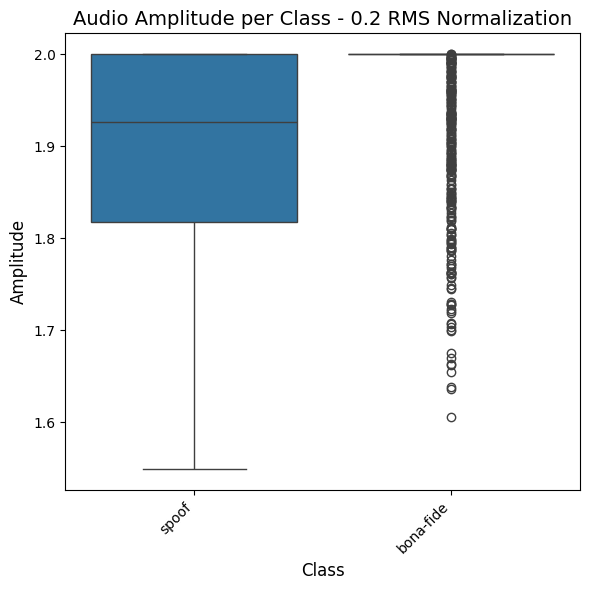

In [10]:
normalize_dataset(f026_df, rms_normalize, target_rms=0.2)
calculate_amplitudes(f026_df, normalized=True)
analyze(f026_df, "0.2 RMS Normalization")

Normalizing dataset...


100%|██████████| 1916/1916 [00:17<00:00, 112.09it/s]


Normalization finished!

Calculation of amplitudes done

Amplitude mean of each class - 0.5 RMS Normalization:

label
bona-fide    1.999969
spoof        1.999969
Name: amplitude, dtype: float32


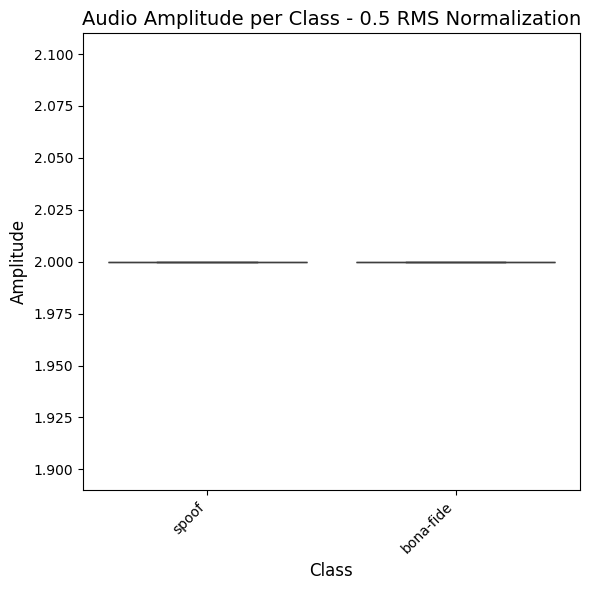

In [11]:
normalize_dataset(f026_df, rms_normalize, target_rms=0.5)
calculate_amplitudes(f026_df, normalized=True)
analyze(f026_df, "0.5 RMS Normalization")

##### Z-Score Normalization

Normalizing dataset...


100%|██████████| 1916/1916 [00:16<00:00, 115.36it/s]


Normalization finished!

Calculation of amplitudes done

Amplitude mean of each class - Z-Score Normalization:

label
bona-fide    1.999969
spoof        1.999969
Name: amplitude, dtype: float32


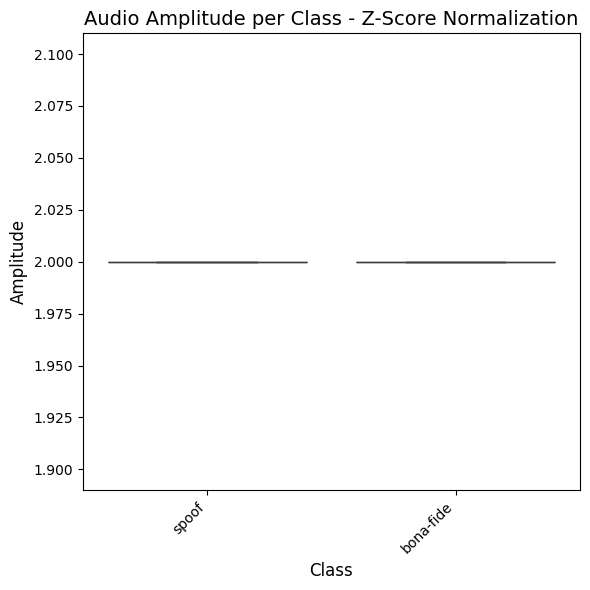

In [12]:
normalize_dataset(f026_df, z_score_normalize)
calculate_amplitudes(f026_df, normalized=True)
analyze(f026_df, "Z-Score Normalization")

##### Peak Normalization

Normalizing dataset...


100%|██████████| 1916/1916 [00:17<00:00, 106.59it/s]


Normalization finished!

Calculation of amplitudes done

Amplitude mean of each class - Peak Normalization:

label
bona-fide    1.821203
spoof        1.789464
Name: amplitude, dtype: float32


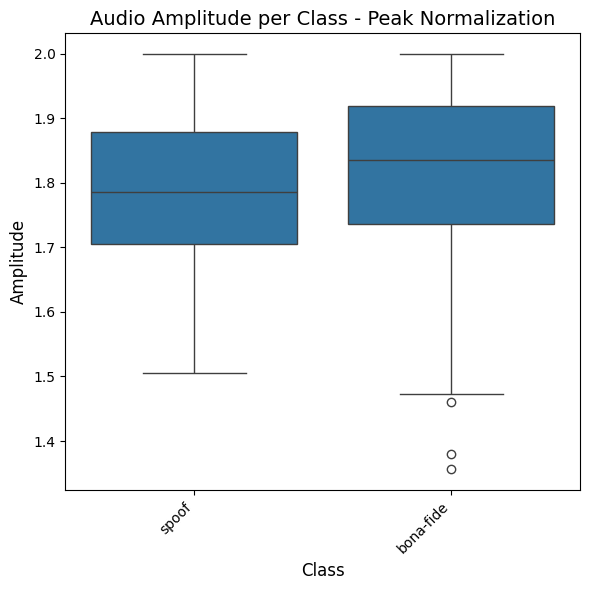

In [13]:
normalize_dataset(f026_df, peak_normalize)
calculate_amplitudes(f026_df, normalized=True)
analyze(f026_df, "Peak Normalization")

[Voltar ao topo](#topo)